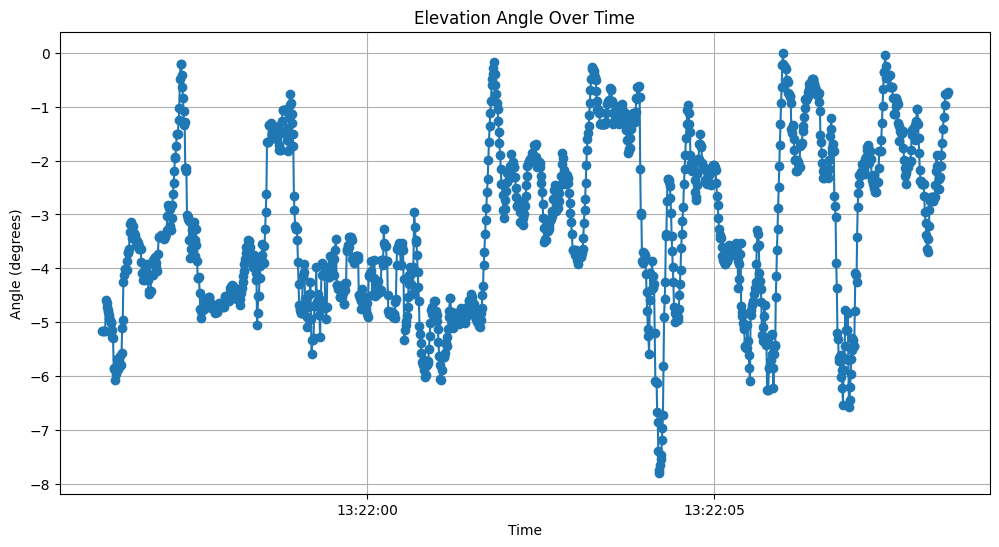

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import deque

# Constants
LASER_BRIGHTNESS_THRESHOLD = 200  # Threshold for laser detection
ROI_WIDTH = 0.3  # Right 30% of image for bend detection
ANGLE_WINDOW_SIZE = 15  # Number of frames for angle averaging
HORIZONTAL_ANGLE_THRESHOLD = 5  # Allowed deviation from horizontal (in degrees)

def detect_horizontal_line(edges, frame_width):
    """
    Detect the horizontal metal sheet in the image.
    Returns the y-coordinate of the horizontal line and its angle.
    """
    # Detect lines using HoughLinesP
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=50,
        minLineLength=50,
        maxLineGap=20
    )

    if lines is None:
        return None, None

    # Filter lines to find the most horizontal one
    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if abs(angle) < HORIZONTAL_ANGLE_THRESHOLD or abs(angle - 180) < HORIZONTAL_ANGLE_THRESHOLD:
            horizontal_lines.append((y1, y2, angle))

    if not horizontal_lines:
        return None, None

    # Average the y-coordinates of the horizontal lines
    y_coords = [y for line in horizontal_lines for y in line[:2]]
    avg_y = int(np.mean(y_coords))
    avg_angle = np.mean([line[2] for line in horizontal_lines])

    return avg_y, avg_angle

def detect_laser(frame, horizontal_y):
    """
    Detect the laser beam as a sudden change in brightness along the vertical axis.
    Returns the vertical coordinate of the laser.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find the brightest pixel in the right ROI
    roi_x = int(frame.shape[1] * (1 - ROI_WIDTH))
    roi = gray[:, roi_x:]
    _, max_val, _, max_loc = cv2.minMaxLoc(roi)

    if max_val < LASER_BRIGHTNESS_THRESHOLD:
        return None

    # Return the vertical coordinate of the laser
    return max_loc[1] + horizontal_y

def calculate_elevation_angle(horizontal_y, laser_y, frame_width):
    """
    Calculate the angle of elevation at the point where the laser is detected.
    """
    if laser_y is None or horizontal_y is None:
        return None

    # Calculate the vertical displacement
    vertical_displacement = horizontal_y - laser_y

    # Calculate the horizontal distance (right side of the laser)
    horizontal_distance = frame_width * ROI_WIDTH

    # Calculate the angle of elevation
    angle = np.arctan2(vertical_displacement, horizontal_distance) * 180 / np.pi
    return angle

def process_video(video_path, output_path=None):
    """Process video stream with laser detection and angle analysis"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Video processing parameters
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Video writer setup if output path specified
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    else:
        out = None

    # State tracking variables
    laser_detected = False
    analysis_start_time = None
    angles = deque(maxlen=ANGLE_WINDOW_SIZE)
    angle_history = []
    timestamps = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess frame for edge detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)

        # Detect the horizontal metal sheet
        horizontal_y, horizontal_angle = detect_horizontal_line(edges, frame_width)

        if horizontal_y is None:
            print("Warning: No horizontal line detected.")
            continue

        # Detect the laser beam
        laser_y = detect_laser(frame, horizontal_y)

        # Calculate the angle of elevation
        angle = calculate_elevation_angle(horizontal_y, laser_y, frame_width)

        if angle is not None:
            angles.append(angle)
            angle_history.append(np.mean(angles))
            timestamps.append(datetime.now())

            # Visual feedback
            cv2.putText(frame, f"Elevation Angle: {np.mean(angles):.1f}°",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Draw the horizontal line and laser point
        if horizontal_y is not None:
            cv2.line(frame, (0, horizontal_y), (frame_width, horizontal_y), (0, 255, 0), 2)
        if laser_y is not None:
            cv2.circle(frame, (int(frame_width * (1 - ROI_WIDTH / 2)), laser_y), 5, (0, 0, 255), -1)

        # Write frame to output
        if out:
            out.write(frame)

        # Display
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()

    # Plot results
    if angle_history:
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, angle_history, marker='o')
        plt.title('Elevation Angle Over Time')
        plt.xlabel('Time')
        plt.ylabel('Angle (degrees)')
        plt.grid(True)
        plt.show()

# Example usage
video_path = "/home/vdnt/Documents/Chanakya_Fellowship/Initial_images/WhatsApp Video 2025-01-27 at 17.47.40.mp4"
process_video(video_path, "output_video.avi")

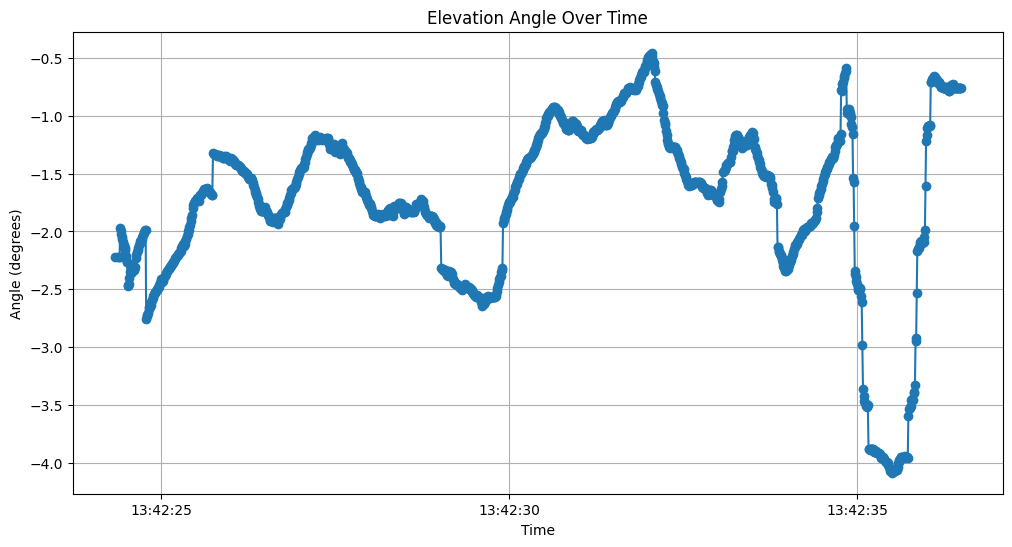

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import deque

# Constants
LASER_BRIGHTNESS_THRESHOLD = 200  # Threshold for laser detection
ROI_WIDTH = 0.7  # Right 30% of image for bend detection
ANGLE_WINDOW_SIZE = 100  # Number of frames for angle averaging
HORIZONTAL_ANGLE_THRESHOLD = 20  # Allowed deviation from horizontal (in degrees)
SHEET_DARKNESS_THRESHOLD = 100  # Threshold for detecting dark pixels of the sheet

def detect_horizontal_line(edges, frame_width, frame_height):
    """
    Detect the horizontal metal sheet in the image.
    Returns the y-coordinate of the horizontal line and its angle.
    """
    # Detect lines using HoughLinesP
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=50,
        minLineLength=50,
        maxLineGap=20
    )

    if lines is None:
        return None, None

    # Filter lines to find the most horizontal one
    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if abs(angle) < HORIZONTAL_ANGLE_THRESHOLD or abs(angle - 180) < HORIZONTAL_ANGLE_THRESHOLD:
            horizontal_lines.append((y1, y2, angle))

    if not horizontal_lines:
        return None, None

    # Average the y-coordinates of the horizontal lines
    y_coords = [y for line in horizontal_lines for y in line[:2]]
    avg_y = int(np.mean(y_coords))
    avg_angle = np.mean([line[2] for line in horizontal_lines])

    return avg_y, avg_angle

def detect_laser(frame, horizontal_y):
    """
    Detect the laser beam as a sudden change in brightness along the vertical axis.
    Returns the vertical coordinate of the laser.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find the brightest pixel in the right ROI
    roi_x = int(frame.shape[1] * (1 - ROI_WIDTH))
    roi = gray[:, roi_x:]
    _, max_val, _, max_loc = cv2.minMaxLoc(roi)

    if max_val < LASER_BRIGHTNESS_THRESHOLD:
        return None

    # Return the vertical coordinate of the laser
    return max_loc[1] + horizontal_y

def calculate_elevation_angle(horizontal_y, laser_y, frame_width):
    """
    Calculate the angle of elevation at the point where the laser is detected.
    """
    if laser_y is None or horizontal_y is None:
        return None

    # Calculate the vertical displacement
    vertical_displacement = horizontal_y - laser_y

    # Calculate the horizontal distance (right side of the laser)
    horizontal_distance = frame_width * ROI_WIDTH

    # Calculate the angle of elevation
    angle = np.arctan2(vertical_displacement, horizontal_distance) * 180 / np.pi
    return angle

def process_video(video_path, output_path=None):
    """Process video stream with laser detection and angle analysis"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Video processing parameters
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Video writer setup if output path specified
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    else:
        out = None

    # State tracking variables
    laser_detected = False
    analysis_start_time = None
    angles = deque(maxlen=ANGLE_WINDOW_SIZE)
    angle_history = []
    timestamps = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess frame for edge detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)

        # Detect the horizontal metal sheet
        horizontal_y, horizontal_angle = detect_horizontal_line(edges, frame_width, frame_height)

        if horizontal_y is None:
            print("Warning: No horizontal line detected.")
            continue

        # Detect the laser beam
        laser_y = detect_laser(frame, horizontal_y)

        # Calculate the angle of elevation
        angle = calculate_elevation_angle(horizontal_y, laser_y, frame_width)

        if angle is not None:
            angles.append(angle)
            angle_history.append(np.mean(angles))
            timestamps.append(datetime.now())

            # Visual feedback
            cv2.putText(frame, f"Elevation Angle: {np.mean(angles):.1f}°",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Draw the horizontal line and laser point
        if horizontal_y is not None:
            cv2.line(frame, (0, horizontal_y), (frame_width, horizontal_y), (0, 255, 0), 2)
        if laser_y is not None:
            cv2.circle(frame, (int(frame_width * (1 - ROI_WIDTH / 2)), laser_y), 5, (0, 0, 255), -1)

        # Write frame to output
        if out:
            out.write(frame)

        # Display
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()

    # Plot results
    if angle_history:
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, angle_history, marker='o')
        plt.title('Elevation Angle Over Time')
        plt.xlabel('Time')
        plt.ylabel('Angle (degrees)')
        plt.grid(True)
        plt.show()

# Example usage
video_path = "/home/vdnt/Documents/Chanakya_Fellowship/Initial_images/WhatsApp Video 2025-01-27 at 17.47.40.mp4"
process_video(video_path, "output_video.avi")

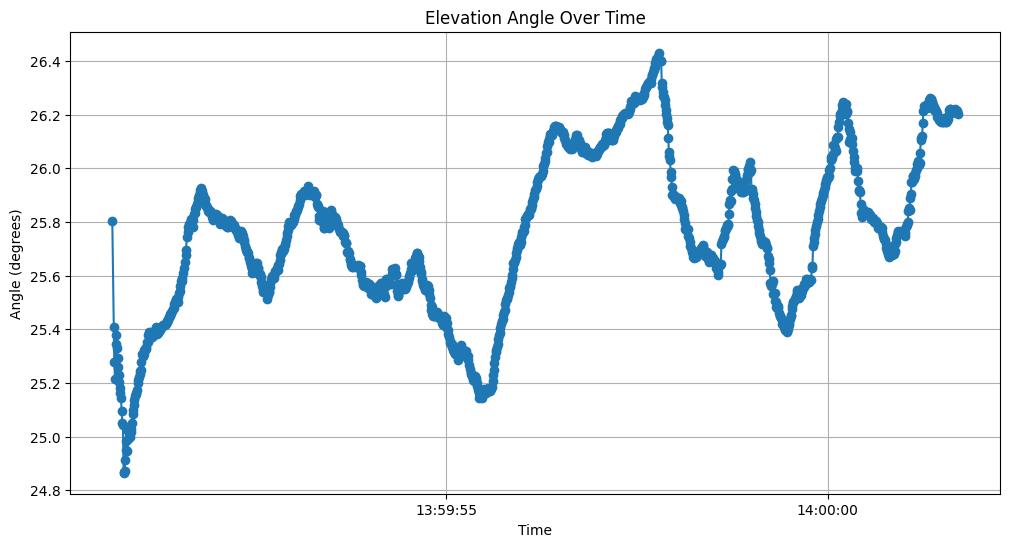

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import deque

# Constants
LASER_BRIGHTNESS_THRESHOLD = 200  # Threshold for laser detection
ROI_WIDTH = 0.7  # Right 30% of image for bend detection
ANGLE_WINDOW_SIZE = 100  # Number of frames for angle averaging
HORIZONTAL_ANGLE_THRESHOLD = 20  # Allowed deviation from horizontal (in degrees)
SHEET_DARKNESS_THRESHOLD = 100  # Threshold for detecting dark pixels of the sheet
CROP_HEIGHT = 300  # Number of pixels to keep above the horizontal line

def detect_horizontal_line(edges, frame_width, frame_height):
    """
    Detect the horizontal metal sheet in the image.
    Returns the y-coordinate of the horizontal line and its angle.
    """
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=50,
        minLineLength=50,
        maxLineGap=20
    )

    if lines is None:
        return None, None

    horizontal_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if abs(angle) < HORIZONTAL_ANGLE_THRESHOLD or abs(angle - 180) < HORIZONTAL_ANGLE_THRESHOLD:
            horizontal_lines.append((y1, y2, angle))

    if not horizontal_lines:
        return None, None

    y_coords = [y for line in horizontal_lines for y in line[:2]]
    avg_y = int(np.mean(y_coords))
    avg_angle = np.mean([line[2] for line in horizontal_lines])

    return avg_y, avg_angle

def crop_frame(frame, horizontal_y):
    """
    Crop the frame to show only CROP_HEIGHT pixels above the horizontal line.
    """
    if horizontal_y is None:
        return frame
    
    # Convert horizontal_y to integer and calculate start_y
    horizontal_y = int(horizontal_y)
    start_y = int(max(0, horizontal_y - CROP_HEIGHT))
    
    # Crop the frame
    cropped_frame = frame[start_y:horizontal_y + 1, :]
    
    return cropped_frame

def detect_laser(frame, horizontal_y):
    """
    Detect the laser beam as a sudden change in brightness along the vertical axis.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    roi_x = int(frame.shape[1] * (1 - ROI_WIDTH))
    roi = gray[:, roi_x:]
    _, max_val, _, max_loc = cv2.minMaxLoc(roi)

    if max_val < LASER_BRIGHTNESS_THRESHOLD:
        return None

    return max_loc[1]  # Return relative to cropped frame

def calculate_elevation_angle(laser_y, frame_width):
    """
    Calculate the angle of elevation at the point where the laser is detected.
    """
    if laser_y is None:
        return None

    # Calculate the vertical displacement (relative to cropped frame bottom)
    vertical_displacement = CROP_HEIGHT - laser_y

    # Calculate the horizontal distance (right side of the laser)
    horizontal_distance = frame_width * ROI_WIDTH

    # Calculate the angle of elevation
    angle = np.arctan2(vertical_displacement, horizontal_distance) * 180 / np.pi
    return angle

def process_video(video_path, output_path=None):
    """Process video stream with laser detection and angle analysis"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    angles = deque(maxlen=ANGLE_WINDOW_SIZE)
    angle_history = []
    timestamps = []

    # Initialize video writer with cropped dimensions
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = None  # We'll initialize it after first frame to get correct dimensions

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess frame for edge detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)

        # Detect the horizontal metal sheet
        horizontal_y, horizontal_angle = detect_horizontal_line(edges, frame_width, frame_height)

        if horizontal_y is None:
            print("Warning: No horizontal line detected.")
            continue

        # Crop the frame
        cropped_frame = crop_frame(frame, horizontal_y)
        
        # Initialize video writer with cropped dimensions if needed
        if output_path and out is None:
            out = cv2.VideoWriter(output_path, fourcc, fps, 
                                (frame_width, cropped_frame.shape[0]))

        # Detect the laser beam in cropped frame
        laser_y = detect_laser(cropped_frame, horizontal_y)

        # Calculate the angle of elevation
        angle = calculate_elevation_angle(laser_y, frame_width)

        if angle is not None:
            angles.append(angle)
            angle_history.append(np.mean(angles))
            timestamps.append(datetime.now())

            # Visual feedback on cropped frame
            cv2.putText(cropped_frame, f"Elevation Angle: {np.mean(angles):.1f}°",
                       (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Draw laser point if detected
        if laser_y is not None:
            cv2.circle(cropped_frame, 
                      (int(frame_width * (1 - ROI_WIDTH / 2)), laser_y),
                      5, (0, 0, 255), -1)

        # Write frame to output
        if out:
            out.write(cropped_frame)

        # Display
        cv2.imshow('Frame', cropped_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()

    # Plot results
    if angle_history:
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, angle_history, marker='o')
        plt.title('Elevation Angle Over Time')
        plt.xlabel('Time')
        plt.ylabel('Angle (degrees)')
        plt.grid(True)
        plt.show()

# Example usage
video_path = "/home/vdnt/Documents/Chanakya_Fellowship/Initial_images/WhatsApp Video 2025-01-27 at 17.47.40.mp4"
process_video(video_path, "output_video.avi")